In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import cv2

In [6]:
PATH = "/Users/dan_yocum/Desktop/github/abalone_length/ml_data/ablob/"
sz = 224
arch = resnet34
bs = 64

In [7]:
m = arch(True)
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.from_model_data(m, data)
learn.load("trained_model")

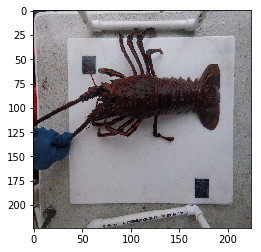

In [9]:
imgName = "G0121700.JPG"
targetPath = "/Users/dan_yocum/Desktop/github/abalone_length/ml_data/ablob/test/lobster/"
#imgName = "blue_abalone_rot.jpg"
#targetPath = "data/ablob/test/abalone/"
#imgName="lobster.jpg"
#targetPath="data/ablob/test/"
targetImagePath = targetPath+imgName
targetImage = Image.open(targetImagePath).resize((224,224))
plt.imshow(targetImage)


In [10]:

ds = FilesIndexArrayDataset([imgName], np.array([0]), tfms[1], targetPath)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

1

## CAM

In [11]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [12]:
x,y = next(iter(dl))

In [30]:
x = x[None,0]
vx = Variable(x.cpu(), requires_grad=True)


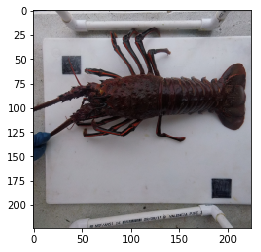

In [31]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [32]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]
sfs

In [33]:
py = m(Variable(x.cpu()))

In [34]:
for o in sfs: o.remove()

In [35]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [36]:
py = np.exp(to_np(py)[0]); py

array([0., 1.], dtype=float32)

In [37]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [38]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.09287, 0.19639, 0.28003, 0.30189, 0.25592, 0.16148, 0.07186],
       [0.24808, 0.49268, 0.66404, 0.69287, 0.59165, 0.3858 , 0.18793],
       [0.4001 , 0.75781, 0.97353, 0.98872, 0.84094, 0.55599, 0.27175],
       [0.43324, 0.80355, 1.     , 0.98666, 0.8246 , 0.55725, 0.28089],
       [0.30285, 0.56204, 0.69196, 0.68574, 0.57838, 0.39664, 0.20038],
       [0.11671, 0.24427, 0.32729, 0.34393, 0.30133, 0.21853, 0.11385],
       [0.     , 0.03236, 0.06697, 0.092  , 0.09878, 0.07981, 0.04354]], dtype=float32)

In [39]:
f2F = np.ma.masked_where(f2 <= 0.7, f2)


In [40]:
filter = scipy.misc.imresize(f2F, dx.shape,mode="L")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [41]:
f2Filtered = np.ma.masked_where(filter <= 150, filter)


In [42]:
minX = 1000
minY = 1000
maxX = 0
maxY = 0

for i in range(0,len(f2Filtered)):
    for j in range(0,len(f2Filtered[0])):
        val = f2Filtered[i][j]
        if val > 0:
            if i < minX:
                minX = i
            if j < minY:
                minY = j
            if i > maxX:
                maxX = i
            if j > maxY:
                maxY = j
xrange = (minX, maxX)
yrange = (minX, maxY)
print("x range: ", xrange)
print("y range: ", yrange)

x range:  (40, 152)
y range:  (40, 171)


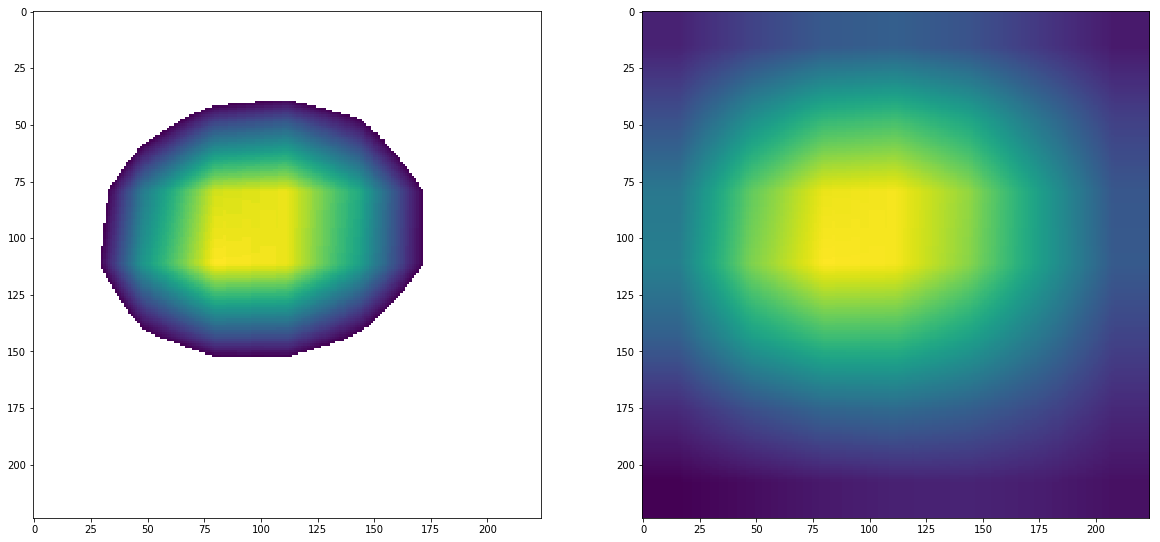

In [43]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,2, 1)
plt.imshow(f2Filtered)
fig.add_subplot(1,2,2)
plt.imshow(filter)
plt.show()

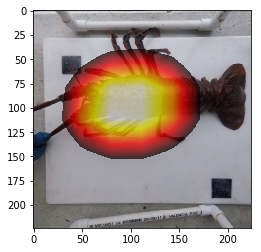

In [47]:
plt.imshow(dx)
plt.imshow(f2Filtered, alpha=0.7, cmap='hot');

## Model